In [1]:
import json
import itertools  # itertools.combinations may be useful
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import streamlit as st
# import altair as alt
import pickle
import plotly.graph_objects as go
import plotly.express as px


In [2]:
def load_json(input):
    # Opening JSON file
    f = open(input)
    # returns JSON object as
    # a dictionary
    data = json.load(f)
    # Closing file
    f.close() 
    return data

In [3]:
# OBSOLETE
def get_cn(key,input):
    data = load_json(input)
    for i,el in enumerate(data["intervals"]):
        if el['iid']==key:
            return el['y']
        else:
            continue

    return 0

In [4]:
def draw_network(G):
    # Set overall figure size
    fig = plt.figure(figsize=(40,40))
    fig.tight_layout()

    nx.draw_networkx(G)

In [5]:
def draw_network_colors(G):
    input = 'SM12_12.json'
    node_list = list(G.nodes())
    cn = []
    for node in node_list:
        cn.append(get_cn(node,input))

    #nx.set_node_attributes(G, cn, 'cn')

    fig = plt.figure(figsize=(70,10))
    ax = fig.add_subplot(111)

    #cmap = plt.cm.get_cmap('rainbow')
    cmap = plt.cm.coolwarm
    vmin = 0
    vmax = max(cn) #if len(cn)>0 else 0
    # nx.draw(G, pos=nx.spring_layout(G), node_color = cn, vmin=vmin, vmax=vmax, cmap=cmap,with_labels=True)

    pos=nx.get_node_attributes(G,'pos')

    xmax = max([v[0] for k,v in pos.items()])
    
    nx.draw_networkx(G, pos, node_shape="s", node_color = cn, node_size=100, font_size=8,
            vmin=vmin, vmax=vmax, cmap=cmap, with_labels=True,
            ax=ax)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm,fraction=0.046, pad=0.04, aspect=10)#https://matplotlib.org/stable/api/colorbar_api.html

    ax.tick_params(left=True, right=True, top=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_title("The Longest Chain")
    ax.set_ylabel("Copy Number")
    ax.set_xlabel("Starting Position/$10^{9}$")
    #ax.set_xlim(0,xmax*1.01)
    #ax.set_xscale("log")
  

In [6]:
def find_longest_chain(G,df):
    diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(G)])
    print("the longest is path length is", diameter)

    # print(df)

    G2=nx.DiGraph()

    how_many_longest = 0

    for (i,j) in nx.shortest_path_length(G):
        # print((i,j),j.values()) # prints as below (the default longest chain)
        # (2798, {2798: 0, 2799: 1, 2800: 2, 2803: 3, 2804: 4, 2806: 5, 2807: 6, 2808: 7}) dict_values([0, 1, 2, 3, 4, 5, 6, 7])

        if max(j.values()) == diameter:

            how_many_longest += 1
            node_list = list(j.keys())
            print("node list and its length:", node_list, len(node_list))

            for n,node in enumerate(node_list):
                x1=int(df[df['Source']==node]['Start_Point'].values[0])
                x2=int(df[df['Source']==node]['End_Point'].values[0])
                y=int(df[df['Source']==node]['Copy_Number'].values[0])           
                
                # Add nodes and connect them                
                G2.add_node(node_list[n],pos=(x1,y))
                if n>0:
                    G2.add_edge(node_list[n-1],node_list[n])

    print("how many with this size:",how_many_longest)

    # print("longest chain -->",G2.nodes)

    return G2,diameter

In [7]:
def getnodeinfo(nodeID,jsonfile):
    # NEEDS ABS VAL OF SOURCE
    # Returns copy number, starpoint, endpoint information
    # from the first part of json file
    # P.S.: returning just el['y'] is the same as get_cn()
    # this returns start and end points of nodes on top of that
    
    data = load_json(jsonfile)

    for i,el in enumerate(data["intervals"]):            
        if el['iid']==nodeID:
            # if nodeID==454:
            #     print("getnodeinfo",el['y'],el['startPoint'],el['endPoint'],el['chromosome'])
            return el['y'],el['startPoint'],el['endPoint'],el['chromosome']
        else:
            continue
    
    print("getnodeinfo can't find the info")

    return 0

In [8]:
def make_dict_of_nodes(jsonfile):
    data = load_json(jsonfile)
    # Iterating through the json

    _nodegroups = [] # recently changed to list of lists. 
    for i,el in enumerate(data["connections"]): # out [:100] for test, otherwise all

        nodeID = abs(el['source'])
        
        if el['type']!='LOOSE':

            if getnodeinfo(nodeID,jsonfile)!=0:
                cn,sp,ep,chr = getnodeinfo(nodeID,jsonfile)
                _nodegroups.append([nodeID,abs(el['sink']),cn,sp,ep,chr]) # dict of lists
            else:
                _nodegroups.append([nodeID,abs(el['sink']),0,0,0,0])
        else:

            # LOOSE EDGES
            if nodeID in _nodegroups:
                # If the node w/ a Sink is detected, don't overwrite it with a Loose type
                continue
            else:
                # If the node doesn't have a Sink, use it with Loose
                # If its data entry with "sink" comes up later, it will overwrite "loose" version of it
                if getnodeinfo(nodeID,jsonfile)!=0:
                    cn,sp,ep,chr = getnodeinfo(nodeID,jsonfile)
                    _nodegroups.append([nodeID,'loose',cn,sp,ep,chr]) # dict of lists
                else:
                    _nodegroups.append([nodeID,'loose',0,0,0,0])

    print("make nodes end",_nodegroups[454]) # just a check
                
    return _nodegroups

In [9]:
def handle_index_column(df):
    df2 = df.rename_axis('Source').reset_index()    
    return df2

In [10]:
def clean_zero_cn_nodes(df):
    return df[df['Copy_Number']!=0]

In [11]:
def position(jsonfile,_df,node):
    x1,x2,y=0,0,0
    if node in set(_df['Source'].to_list()):
        x1=int(_df[_df['Source']==node]['Start_Point'].values[0])
        x2=int(_df[_df['Source']==node]['End_Point'].values[0]) # no use for now
        y=int(_df[_df['Source']==node]['Copy_Number'].values[0])
    else:
        # some nodes doesn't have Source entry so we need to go back to the source
        # we can improve this later
        data = load_json(jsonfile)
        for i,el in enumerate(data["intervals"]):            
            if el['iid']==node:
                x1=el['startPoint']
                x2=el['endPoint']
                y=el['y']
            else:
                continue

    
    if node!='loose' and (x1==0 or x2==0):
        print("CAN'T FIND LOCATION DATA FOR",node)

    return x1,y

In [12]:
def make_df(jsonfile):
    print("Creating a DataFrame object")
    #df = make_df(jsonfile) # nodeID(source)| sink | CN(y) | start p | end p
    nodedict = make_dict_of_nodes(jsonfile) # this is a dict of lists
    #  = nodeID(source)| sink | CN(y) | start p | end p
    
    # now turn this into a pandas dataframe
    df = pd.DataFrame(nodedict, columns =['Source','Sink', 'Copy_Number','Start_Point', 'End_Point','Chromosome'])
    
    # df.columns =['Sink', 'Copy_Number','Start_Point', 'End_Point','Chromosome']
    # df2 = handle_index_column(df)

    print(df)

    print("Cleaning DF object from nodes with 0 copy number")
    df_c = clean_zero_cn_nodes(df)
    
    return df,df_c

In [13]:
def make_graph(jsonfile,df):
    G=nx.DiGraph()
    
    print("Constructing the graph")
    # from DF directly, however it sees nan values as a single node of 'nan'
    # G=nx.from_pandas_edgelist(df, 'Source', 'Sink') 

    # Alternative way
    # G.add_edges_from(zip(df_c['Source'].tolist(),df_c['Sink'].tolist())) # Will clean loose later - this gives longest 121 

    # Alternative way to include position info
    for n,node in enumerate(set(df['Source'].tolist())):
        if int(df[df['Source']==node]['Copy_Number'].values[0])!=0: # if CN=0, don't waste your time in this node
            G.add_node(node,pos=position(jsonfile,df,node))
            for index,row in df[df['Source']==node].iterrows(): # a node can have more than one connection
                # looping over rows is not ideal in pandas, but the loops should be very small here
                # row[0]=source, row[1]=sink, row[2]=cn, row[3]=sp, row[4]=ep, row[5]=chromosome
                if row[1] != 'loose' and df[df['Source']==row[1]]['Copy_Number'].values.size>0: # don't make the node='loose'
                    if int(df[df['Source']==row[1]]['Copy_Number'].values[0])!=0: # if CN=0, don't waste your time in this node
                        G.add_node(row[1],pos=position(jsonfile,df,row[1])) 
                        G.add_edge(row[0],row[1])   
        else:
            continue

    # just a check, b/c in the previous version that has nodes with cn=0, loose was a node
    if 'loose' in list(G.nodes):
        print("Loose is counted as a node") 

    return G

In [14]:
# Seperated this from the cell below to speed up debugging
jsonfile = 'SM12_12.json'
df,df_c = make_df(jsonfile)

Creating a DataFrame object
make nodes end [640, 641, 5, 12180241, 12260979, '12']
      Source   Sink  Copy_Number  Start_Point  End_Point Chromosome
0       1545   1585            7     23820865   23821002         13
1       1508   1509            8     22132854   22133231         13
2       1506   1565            7     22111602   22111802         13
3       1376   1377            6     76152669   76153228         12
4       1373   1540           30     75632352   75632602         12
...      ...    ...          ...          ...        ...        ...
7226    3649  loose            2    141108003  152679002          X
7227    3651  loose            2    152789003  154151402          X
7228    3653  loose            2    154291603  155701002          X
7229    3656  loose            8     11289803   11334602          Y
7230    3658  loose            8     56821603   56881602          Y

[7231 rows x 6 columns]
Cleaning DF object from nodes with 0 copy number


In [15]:
# Construct the graph from df
_graph = make_graph(jsonfile,df) 

Constructing the graph


In [16]:
for edge in _graph.edges():
    if edge[0]==52 or edge[1]==52:
        print(edge)
        print(edge[0],_graph.nodes[edge[0]])
        print(edge[1],_graph.nodes[edge[1]])
    else:
        continue

(52, 53)
52 {'pos': (16673603, 1)}
53 {'pos': (16690803, 4)}


In [29]:
# pickle.dump(df, open('saved_variables/dataframe_v2.txt', 'wb'))
# #pickle.dump(df_c, open('saved_variables/dataframe_clean_cn0.txt', 'wb'))
# pickle.dump(_graph, open('saved_variables/graph_v2.txt', 'wb'))

# df = pickle.load(open('saved_variables/dataframe.txt','rb'))
# df_c = pickle.load(open('saved_variables/dataframe_clean_cn0.txt','rb'))
# _graph = pickle.load(open('saved_variables/graph.txt','rb'))

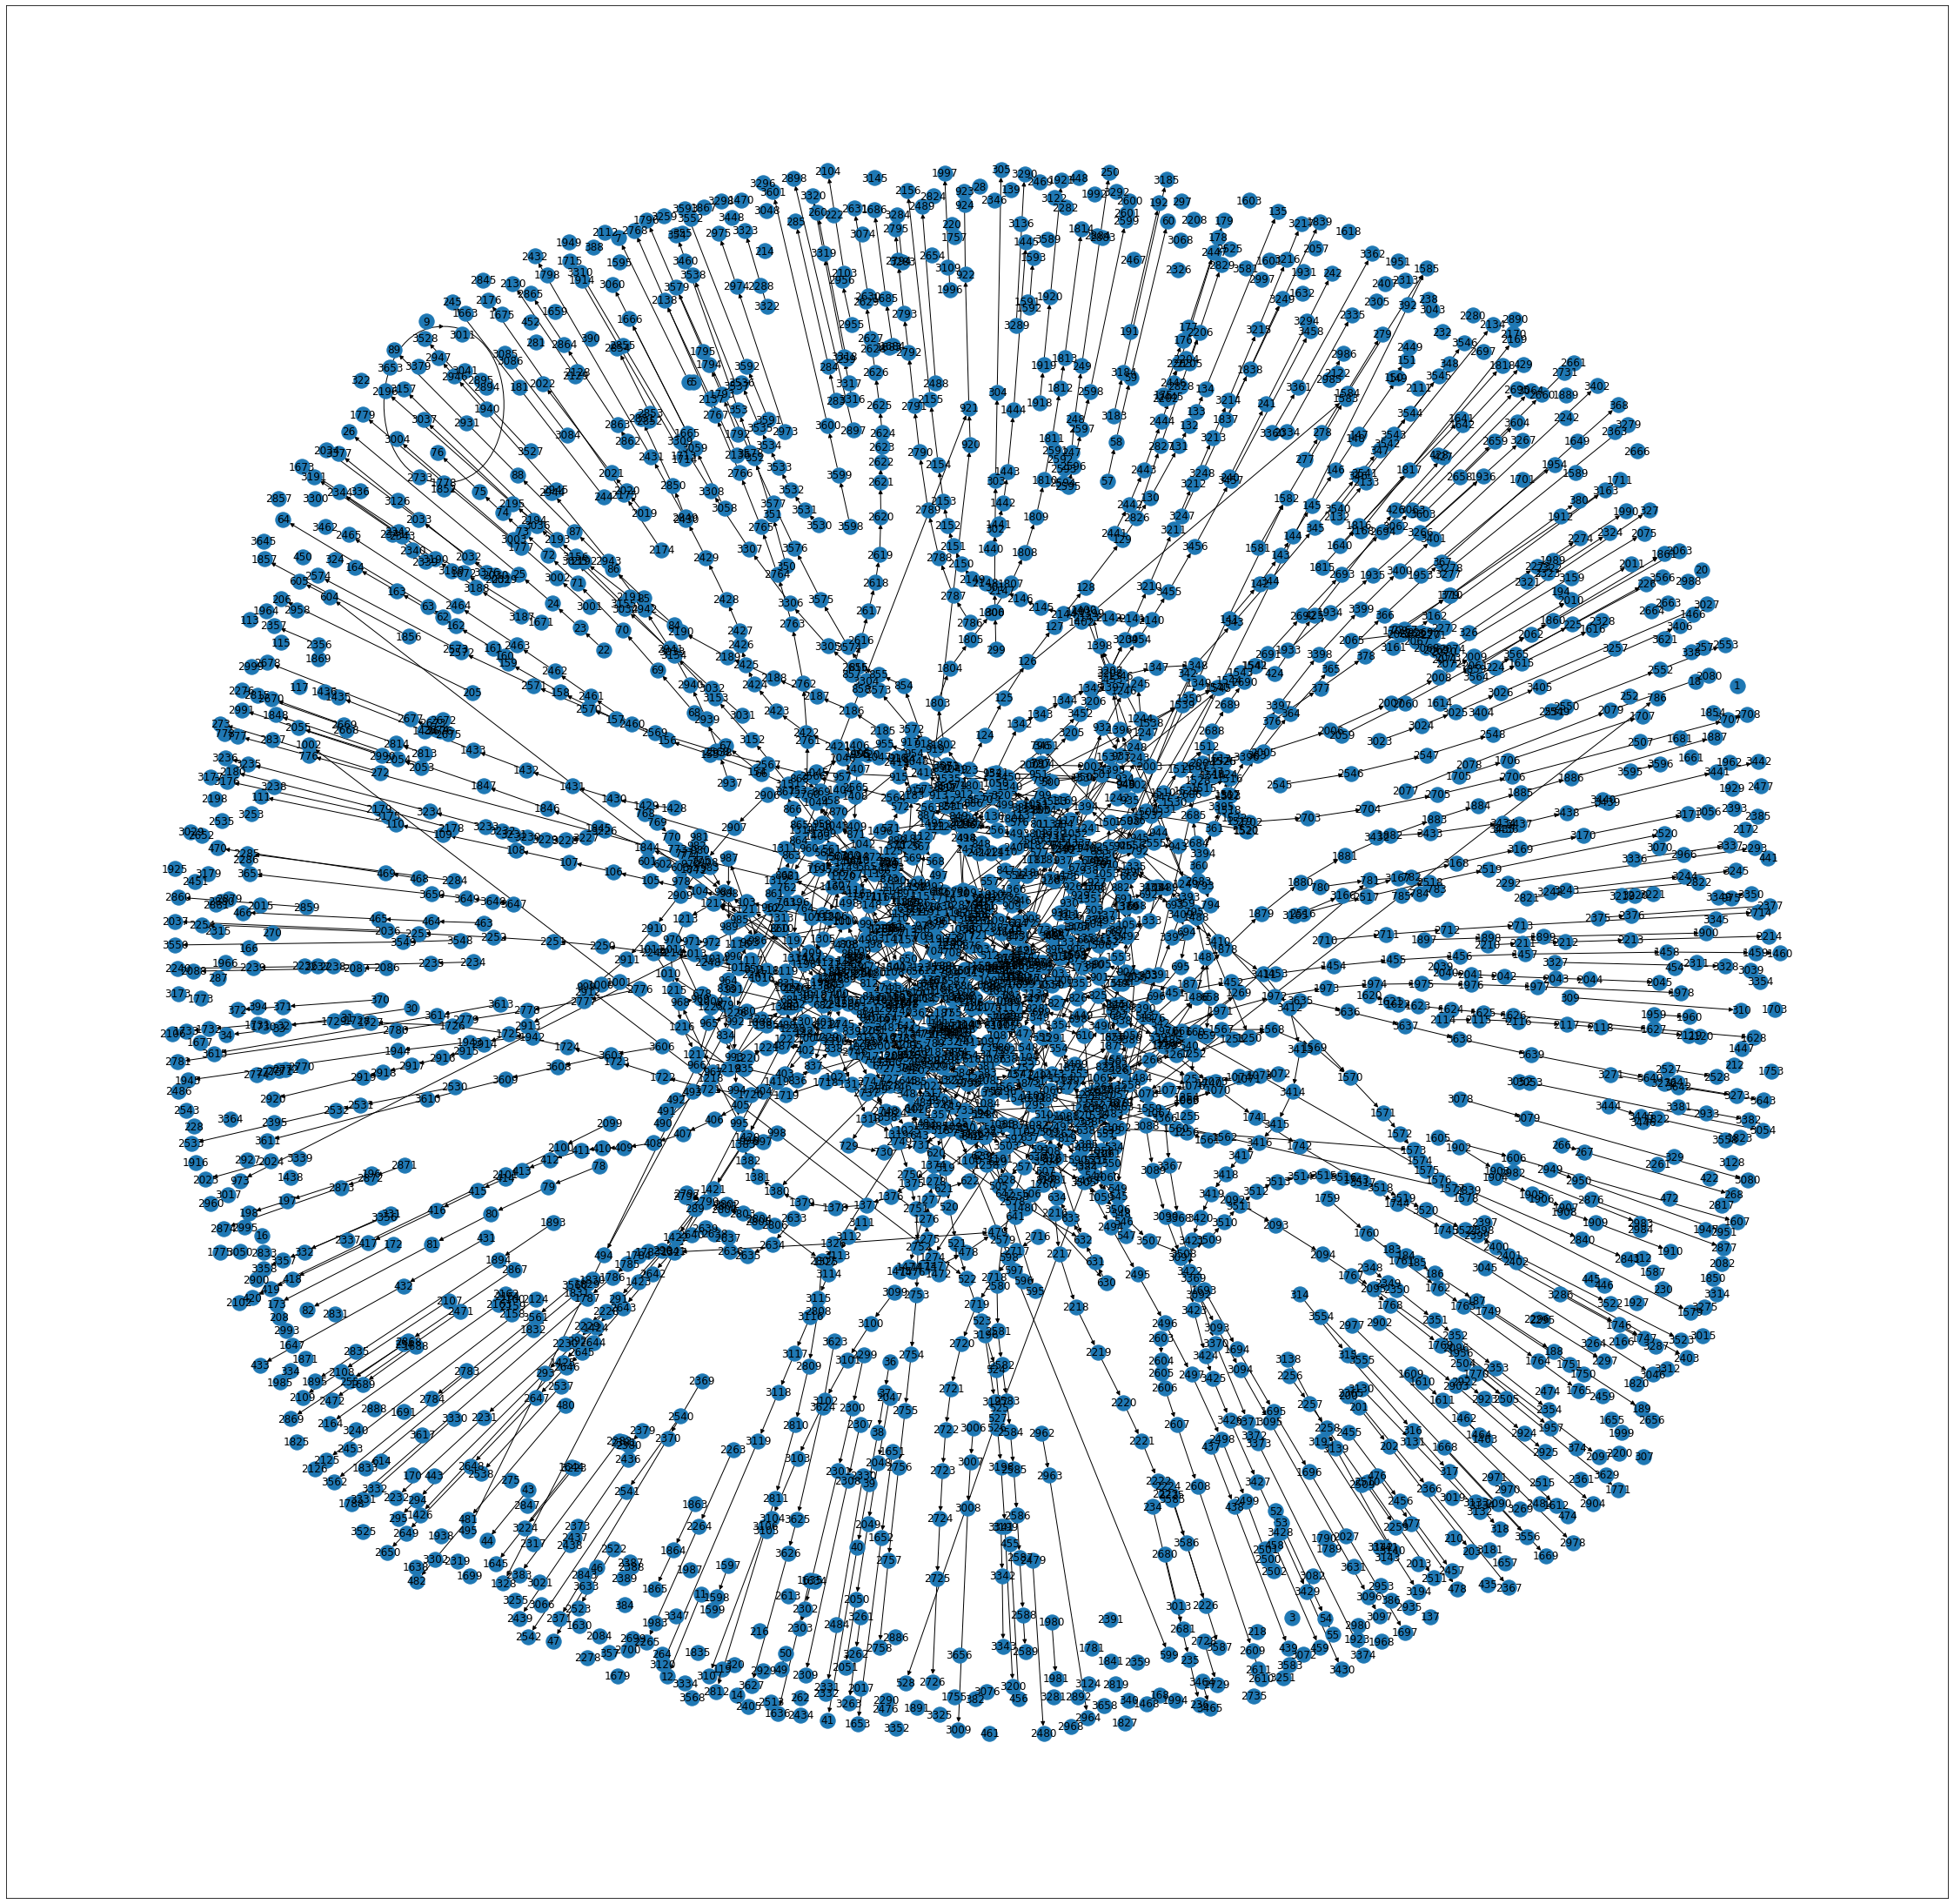

In [18]:
# _graph.remove_node('loose')
draw_network(_graph)

## FIND LONGEST CHAIN

the longest is path length is 145
node list and its length: [1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1266, 1066, 1067, 1298, 1267, 1299, 1068, 1268, 1069, 1070, 1300, 1269, 1271, 781, 1071, 1301, 1270, 1272, 782, 1072, 1302, 1273, 783, 1073, 1489, 1303, 1274, 784, 1490, 1074, 1304, 1275, 785, 1491, 1075, 1305, 1276, 786, 1076, 1492, 1078, 1306, 1277, 1493, 1077, 1079, 1307, 1278, 1474, 1494, 1080, 1308, 1279, 1280, 1475, 1495, 1081, 1309, 1281, 1476, 1496, 1082, 1310, 1282, 1477, 1497, 1083, 1311, 1312, 1283, 1478, 1498, 1084, 1313, 1284, 486, 1479, 1499, 1085, 1314, 1285, 1286, 487, 1480, 1500, 1086, 1315, 1287, 488, 1481, 1501, 1087, 1088, 515, 1316, 1288, 489, 1482, 1502, 1089, 516, 1317, 1192, 1289, 490, 1483, 1503, 1504, 1090, 517, 1318, 1193, 1290, 491, 1484, 1505, 1091, 

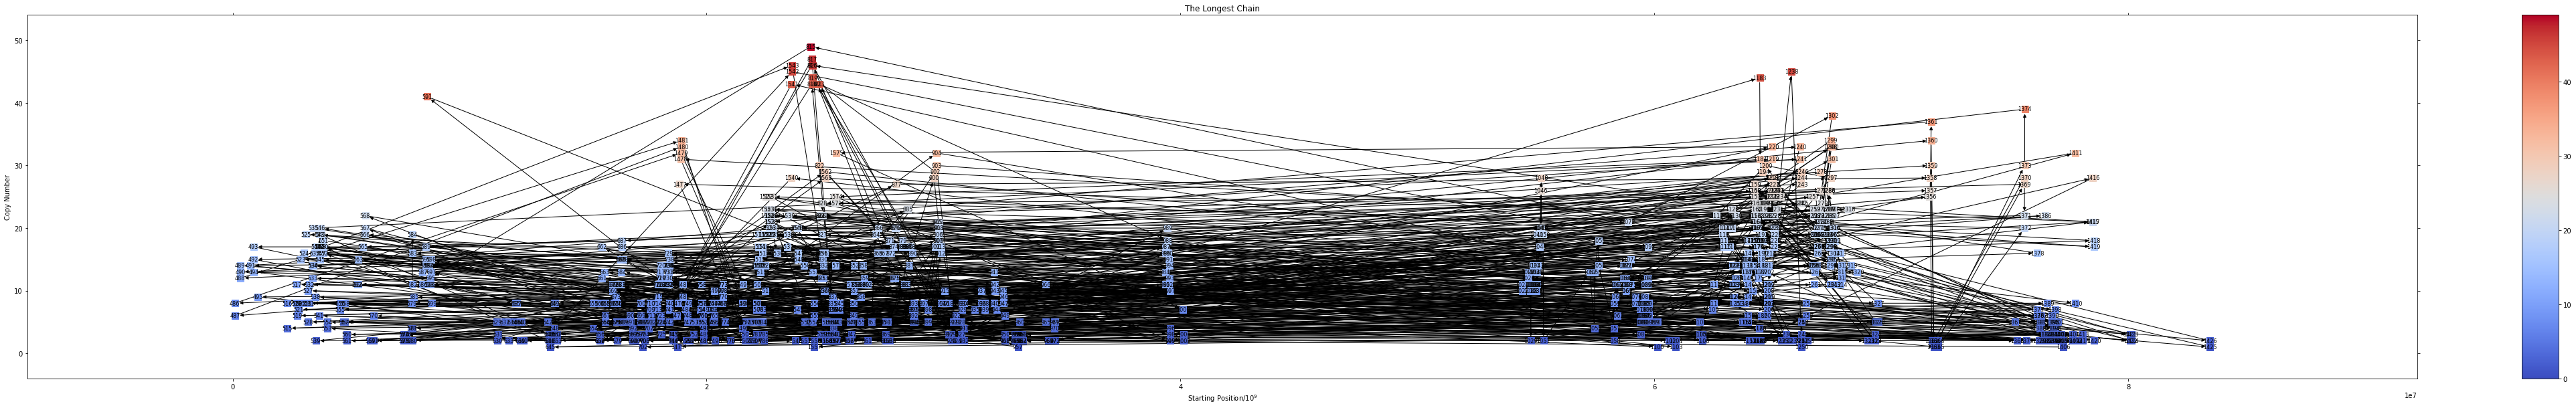

In [19]:
longest_graph,largest_diameter = find_longest_chain(_graph,df)
draw_network_colors(longest_graph)

In [30]:
# Dump again or load longest chain faster
# pickle.dump(longest_graph, open('saved_variables/longest_chain_v2.txt', 'wb'))
# longest_graph = pickle.load(open('saved_variables/longest_chain.txt','rb'))

## PLOTLY TEST

In [21]:
def draw_plotly(G):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        print(edge)
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = [] # position
    node_y = [] # copy number
    node_id = [] # node id
    node_chr = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        node_id.append(node)
        if df[df['Source']==node].Chromosome.values[0] == 'X':
            node_chr.append(23)
        elif df[df['Source']==node].Chromosome.values[0] == 'Y':
            node_chr.append(24)
        elif df[df['Source']==node].Chromosome.values[0] == 'M':
            node_chr.append(25)
        else:
            node_chr.append(int(df[df['Source']==node].Chromosome.values[0])) # item() returns numbers as str
    
    unique_values = len(set(df.Chromosome.to_list()))
    unique_values = len(set(node_chr))
    color_bar_values = [val for val in np.linspace(0, 1, unique_values+1) for _ in range(2)]
    discrete_colors = [val for val in px.colors.qualitative.Alphabet for _ in range(2)]
    colorscale = [[value, color] for value, color in zip(color_bar_values, discrete_colors[1:])]
    colorscale.pop(0)
    colorscale.pop(-1)

    ### Compile hover text for each node
    node_text = []
    for n,node in enumerate(G.nodes()):
        next_node='None' if n==len(G.nodes())-1 else list(G.nodes())[n+1]
        prev_node='None' if n==0 else list(G.nodes())[n-1]
        if node_chr[n]==23:
            node_text.append(f'Node:{node} | Prev: {prev_node} | Next: {next_node} | Chromosome: X | CN: {node_y[n]}' )
        elif node_chr[n]==24:
            node_text.append(f'Node:{node} | Prev: {prev_node} | Next: {next_node} | Chromosome: Y | CN: {node_y[n]}')
        elif node_chr[n]==25:
            node_text.append(f'Node:{node} | Prev: {prev_node} | Next: {next_node} | Chromosome: M | CN: {node_y[n]}')
        else:
            node_text.append(f'Node:{node} | Prev: {prev_node} | Next: {next_node} | Chromosome: {node_chr[n]} | CN: {node_y[n]}')


    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            # colorscale=px.colors.qualitative.Light24,
            colorscale=colorscale,
            reversescale=True,
            color=node_chr,
            size=10,
            symbol=0,
            colorbar=dict(
                thickness=15,
                title='Chromosome Number',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # Can also be assigned later like below
    # node_trace.text = node_id
    # node_trace.marker.color = node_chr

    fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Network graph of the longest chain',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=15,r=5,t=40),
                    annotations=[ dict(
                        text=f"Number of nodes: {len(node_y)}",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.1, y=1 ) ],
                    xaxis=dict(showgrid=True, zeroline=True, showticklabels=True,showline=True,title_text = "Copy Number"),
                    yaxis=dict(showgrid=True, zeroline=True, showticklabels=True,showline=True,title_text = "Start Point"))
                    )
    fig.show()

In [22]:
draw_plotly(longest_graph)

(1024, 1025)
(1025, 1026)
(1026, 1027)
(1027, 1028)
(1028, 1029)
(1029, 1030)
(1030, 1031)
(1031, 1032)
(1032, 1033)
(1033, 1034)
(1034, 1035)
(1035, 1036)
(1036, 1037)
(1037, 1038)
(1038, 1039)
(1039, 1040)
(1040, 1041)
(1041, 1042)
(1042, 1043)
(1043, 1044)
(1044, 1045)
(1045, 1046)
(1046, 1047)
(1047, 1048)
(1048, 1049)
(1049, 1050)
(1050, 1051)
(1051, 1052)
(1052, 1053)
(1053, 1054)
(1054, 1055)
(1055, 1056)
(1056, 1057)
(1057, 1058)
(1058, 1059)
(1059, 1060)
(1060, 1061)
(1061, 1062)
(1062, 1063)
(1063, 1064)
(1064, 1065)
(1065, 1266)
(1266, 1066)
(1066, 1067)
(1067, 1298)
(1298, 1267)
(1267, 1299)
(1299, 1068)
(1068, 1268)
(1268, 1069)
(1069, 1070)
(1070, 1300)
(1300, 1269)
(1269, 1271)
(1271, 781)
(781, 1071)
(1071, 1301)
(1301, 1270)
(1270, 1272)
(1272, 782)
(782, 1072)
(1072, 1302)
(1302, 1273)
(1273, 783)
(783, 1073)
(1073, 1489)
(1489, 1303)
(1303, 1274)
(1274, 784)
(784, 1490)
(1490, 1074)
(1074, 1304)
(1304, 1275)
(1275, 785)
(785, 1491)
(1491, 1075)
(1075, 1305)
(1305, 12

In [23]:
draw_plotly(_graph)

(5, 6)
(6, 7)
(11, 12)
(22, 23)
(23, 24)
(24, 25)
(25, 26)
(30, 31)
(31, 32)
(32, 33)
(33, 34)
(36, 37)
(37, 38)
(38, 39)
(39, 40)
(40, 41)
(43, 44)
(46, 47)
(49, 50)
(52, 53)
(53, 54)
(54, 55)
(57, 58)
(58, 59)
(59, 60)
(62, 63)
(63, 64)
(66, 67)
(67, 68)
(68, 69)
(69, 70)
(70, 71)
(71, 72)
(72, 73)
(73, 74)
(74, 75)
(75, 76)
(78, 79)
(79, 80)
(80, 81)
(81, 82)
(84, 85)
(85, 86)
(86, 87)
(87, 88)
(88, 89)
(91, 92)
(92, 93)
(93, 94)
(94, 95)
(95, 96)
(96, 97)
(97, 98)
(98, 99)
(99, 100)
(100, 101)
(101, 102)
(102, 103)
(103, 104)
(104, 105)
(105, 106)
(106, 107)
(107, 108)
(108, 109)
(109, 110)
(110, 111)
(121, 122)
(122, 123)
(123, 124)
(124, 125)
(125, 126)
(126, 127)
(127, 128)
(128, 129)
(129, 130)
(130, 131)
(131, 132)
(132, 133)
(133, 134)
(134, 135)
(141, 142)
(142, 143)
(143, 144)
(144, 145)
(145, 146)
(146, 147)
(147, 148)
(148, 149)
(149, 150)
(150, 151)
(153, 154)
(154, 155)
(155, 156)
(156, 157)
(157, 158)
(158, 159)
(159, 160)
(160, 161)
(161, 162)
(162, 163)
(163, 164)
(1

In [24]:
simplecycles = nx.simple_cycles(_graph)

In [33]:
simplecycles

<generator object simple_cycles at 0x7f94fa241000>